## <h2 align="center">Plant-Pathology-2021-FGVC8</h2>
![Plant-Pathology-2021-FGVC8](https://storage.googleapis.com/kaggle-competitions/kaggle/25563/logos/header.png?t=2021-02-28-03-55-21&quot "Plant-Pathology-2021-FGVC8")
***
Problem Statement Apples are one of the most important temperate fruit crops in the world. Foliar (leaf) diseases pose a major threat to the overall productivity and quality of apple orchards. The current process for disease diagnosis in apple orchards is based on manual scouting by humans, which is time-consuming and expensive. Although computer vision-based models have shown promise for plant disease identification, there are some limitations that need to be addressed. Large variations in visual symptoms of a single disease across different apple cultivars, or new varieties that originated under cultivation, are major challenges for computer vision-based disease identification. These variations arise from differences in natural and image capturing environments, for example, leaf color and leaf morphology, the age of infected tissues, non-uniform image background, and different light illumination during imaging etc. Plant Pathology 2020-FGVC7 challenge competition had a pilot dataset of 3,651 RGB images of foliar disease of apples. For Plant Pathology 2021-FGVC8, we have significantly increased the number of foliar disease images and added additional disease categories. This year’s dataset contains approximately 23,000 high-quality RGB images of apple foliar diseases, including a large expert-annotated disease dataset. This dataset reflects real field scenarios by representing non-homogeneous backgrounds of leaf images taken at different maturity stages and at different times of day under different focal camera settings. Specific Objectives The main objective of the competition is to develop machine learning-based models to accurately classify a given leaf image from the test dataset to a particular disease category, and to identify an individual disease from multiple disease symptoms on a single leaf image. In this task, our group will complete the multi label classification task for apple leaf diseases. We have adopted different training strategies, including k-fold cross validation and cutmix data augmentation, but not limited to these.
***
Author: June861
***
## Table Of Contents
1. [Importing Dependencies](#1)
2. [Init Configs](#2)
3. [Display Datas](#3)
4. [Import Dataset](#4)
5. [Data Enhancement](#5)
6. [Cutmix Enhancement](#6)
7. [Evaluating Metric](#7)
8. [Loss Function](#8)
9. [Log Function](#9)
10. [Traning Function](#10)
11. [Validation Function](#11)
12. [Draw Function](#12)
13. [Main Code](#13)
***

## <a id=1>Importing Dependencies</a>

1. You can use two commandas to install albumentations and efficientnet_pytorch library.
```python
%pip install albumentations
%pip install efficientnet_pytorch
```

In [2]:
# %pip install albumentations
# %pip install efficientnet_pytorch

In [3]:
# import necessary libraries
import os
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torchvision
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import torch.utils as utils
import cv2
import random
import math
import time
import logging
import sys
import pickle

from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
from skimage import io
from PIL import Image
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets, transforms
from torchvision import models
from sklearn.metrics import zero_one_loss,accuracy_score,precision_score, recall_score, f1_score,hamming_loss
from sklearn.model_selection import train_test_split,KFold
from scipy.ndimage import gaussian_filter1d

# !pip install -U git+https://github.com/albumentations-team/albumentations
sys.path.append("/home/u2020212236/jupyterlab/albumentations-master")
import albumentations as A
from albumentations.pytorch import ToTensorV2

%matplotlib inline

## <a id=2>Init Configs</a>
+ File Path parameters :
    + output_dir : Path where the output file is located
    + logger_dir : Path where the log file is located
    + root : the root path.
    + train_root/test_root : the path where the train/test datas is located.
    + checkpoints_root : the path which is used to save checkpoints file.
+ EPOCH : Number of iterations for training
+ batch_size : Size of batch data
+ n_fold : the number of k-fold cross validation
+ num_classes : the number of labels
+ labels: the real values of labels
+ mean/std : Variance and mean of images
+ train(valid)_batch_size: the number of each batch size for training datas(validation datas)
+ pretrained: whether use a pretrained model.

In [5]:
class CFG:
    EPOCH = 5
    train_batch_size = 20
    valid_batch_size = 100
    lr = 1e-3
    seed = 0
    pretrained = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    img_width = 300
    img_height = 300
    n_epochs = 10
    n_folds = 5
    train_size = 0.9
    valid_size = 0.1
    output_dir = '/kaggle/working/'
    logger_path = "/kaggle/working/train_ensemble.log"
    checkpoints_root = '/kaggle/working/'
    root = '/kaggle/input/plant-pathology-2021-fgvc8'
    train_root = '/kaggle/input/plant-pathology-2021-fgvc8/train_images/'
    test_root = '/kaggle/input/plant-pathology-2021-fgvc8/test_images'
    labels = ['healthy','complex', 'frog_eye_leaf_spot', 'powdery_mildew', 'rust', 'scab']
    class_weights = None
    healthy_index = 0
    num_classes = len(labels)
    indexs = torch.tensor([i for i in range(1,num_classes)]).to(device)
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    blance_classes = []
    drop_after_epoch = [2]

# set random seed
np.random.seed(CFG.seed)
torch.random.seed()
torch.manual_seed(CFG.seed)
torch.cuda.manual_seed_all(CFG.seed)

## <a id=2>Display Datas</a>
The dataset is divided into two parts, one is training datas and the other is testing datas. The test data is not visible (only three images)
+ test_images: Folder for storing test sets
+ train_images: Folder for storing training datas
+ sample_submission.csv : a example file for submission
+ train.csv : messages for training datas

In [6]:
train_csv = pd.read_csv(os.path.join(os.getcwd(),"train.csv"))
train_csv

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [7]:
train_csv["labels"].value_counts()

scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

In [8]:
# Convert relative paths to absolute paths
train_csv["image"] = train_csv["image"].apply(lambda x: CFG.train_root + x)
train_csv

,image,labels
0,/home/u2020212236/jupyterlab/train_images/8001...,healthy
1,/home/u2020212236/jupyterlab/train_images/8002...,scab frog_eye_leaf_spot complex
2,/home/u2020212236/jupyterlab/train_images/8007...,scab
3,/home/u2020212236/jupyterlab/train_images/8007...,scab
4,/home/u2020212236/jupyterlab/train_images/800c...,complex
...,...,...
18627,/home/u2020212236/jupyterlab/train_images/fffb...,healthy
18628,/home/u2020212236/jupyterlab/train_images/fffc...,scab
18629,/home/u2020212236/jupyterlab/train_images/fffc...,rust
18630,/home/u2020212236/jupyterlab/train_images/fffe...,scab frog_eye_leaf_spot


## <a id=4>Import Dataset</a>
In this section, Dataset class will be defined. It will be used to load datas. 

In [10]:
class PlantDataset(Dataset):
    def __init__(self,root,transforms,df,kf,labels=CFG.labels,mode="train"):
        """
        Initialization function.

        Parameters:
        -----------
        root: The path where the training data is located, which corresponds to
              /kaggle/input/plant pathology-2021-fgvc8/train_images/ in this task.
        transforms: Image enhancement.
        df: The dataframe corresponding to the data, which includes two 
            attributes: 'image' and 'labels'
        Kf: k-fold data, where kf stores subscripts.
        labels: real labels.
        mode: Mode, usually training mode and validation mode, with the default 
              value being training mode

        Returns:
        --------
        None

        """
        assert mode in ["train","valid"]
        self.root = root
        self.transforms = transforms
        self.mode = mode
        self.labels = labels
        self.kf = kf
        self.datas = None
        self.datas = df
    
    def __getitem__(self,item):
        """
        item : the index of self.kf
        """
        image = cv2.imread(str( self.datas['image'][self.kf[item]] ))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # one-hot编码
        y = str( self.datas['labels'][self.kf[item]] ).split(" ")
        
        encoder = [0.0 for i in range(len(self.labels))]
        for i,label in enumerate(self.labels):
            if label in y:
                encoder[i] = 1.0
        # image = cv2.resize(image, (CFG.img_width, CFG.img_height), cv2.INTER_AREA)
        y = torch.from_numpy(np.array(encoder))
        image = self.transforms(image=image)
        return image , y
    
    def __len__(self):
        return self.kf.shape[0]
                
            

## <a id=5>Data Enhancement</a>
+ Resize: Zoom the image to the specified size
+ HueSaturationValue: Randomly change the color and saturation values of an image
+ Flip: Flip horizontally, vertically, or horizontally and vertically
+ HorizontalFlip: Flip horizontally, vertically, or horizontally and vertically
+ ShiftScaleRotate: Flip horizontal. 
+ RandomBrightnessContrast: Randomly change the contrast and illumination of an image.
+ Blur | GaussNoise | MotionBlur | ISONoise : Applying noise to images.
+ GridDropout | CoarseDropout: Randomly remove some pixels

In [11]:
train_transformations = A.Compose([
                            A.Resize(CFG.img_width, CFG.img_height),
                            A.HueSaturationValue(p=0.5),
                            A.Flip(p=0.5),
                            A.HorizontalFlip(p=0.5),
                            A.ShiftScaleRotate(p=0.5, shift_limit=(-0.1, 0.3), scale_limit=(-0.1, 0.6), rotate_limit=(-90, 90), interpolation=0, border_mode=2),
                            A.RandomBrightnessContrast(p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2)),
                            A.OneOf([
                                A.Blur(p=0.7),
                                A.GaussNoise(p=0.7, var_limit=(100, 400)),
                                A.MotionBlur(p=0.7),
                                A.ISONoise(p=0.7),
                            ], p=0.5),
                            A.OneOf([
                                A.GridDropout(ratio=0.3, p=0.5),
                                A.CoarseDropout(p=0.5, max_holes=40, max_height=20, max_width=20, min_holes=8, min_height=8, min_width=8),
                            ], p=0.5),
                            A.Normalize(
                                CFG.mean, CFG.std,
                            ),
                            ToTensorV2(),
])


valid_transformations = A.Compose([
                            A.Resize(CFG.img_width, CFG.img_height),
                            A.Normalize(
                                CFG.mean, CFG.std,
                            ),
                            ToTensorV2(),
])

## <a id=6>Cutmix Enhancement</a>
Cutmix refers to cutting out a portion of an area without filling 0 pixels, and randomly filling the pixel values of other data areas in the training set. The classification results are allocated in a certain proportion. The reason why we use it in our work is because plant-pathogy-2021-fgvc8 competition is a multi label classification task, but only a few multi label instances can be used in the original dataset. Therefore, we use the Cutmix data augmentation method to obtain mixed images with multiple labels.

In [12]:
def cutmix(data, target, alpha,indexs):
    """
    Cutmix data augmentation
    
    Parameters:
    ----------
    data: Data to be enhanced.
    target: Real label.
    alpha: adjustable parameter.
    indexes: used to segment tensors and select labels other than 'health'.
    
    
    Returns:
    --------
    data: Returns data after cutmix.
    target_ a: The corresponding label order before cutmix.
    target_ b: Corresponding label order after cutmix.
    ending_ Target: Mixed labels after cutmix (considering label masking).
    lam: Cutmix ratio.
    flags: An array of flags used to record which data needs to be masked 
           for 'health' after being mixed in Cutmix.

    """
    flags = []
    
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]

    lam = np.random.beta(alpha, alpha)
    lam = max(lam, 1 - lam)

    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = shuffled_data[:, :, bbx1:bbx2, bby1:bby2]
    # Adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    # Compute output
    target_a = target
    target_b = shuffled_target
    
    # 计算哪些样本的"healthy"需要被置为0
    # ending_target = (target.bool() | shuffled_target.bool()).float().to(CFG.device)
    # [1,0,0,1,0,0] mix with [0,1,1,0,1,0] and lam = 0.3  -->  [0.3, 0.7, 0.7, 0.3, 0.7, 0.0]
    ending_target = (lam * target + (1-lam) * shuffled_target).to(CFG.device)
    sub_labels = torch.index_select(ending_target,dim=1,index = indexs).to(CFG.device)
    sum_of_other_labels = torch.sum(sub_labels,dim=1).to(CFG.device)

    # target_a 以及 target_b 对 healthy进行遮蔽
    for i in range(sum_of_other_labels.shape[0]):
        if ending_target[i,0] > 0 and sum_of_other_labels[i] > 0 :
            ending_target[i,0] = 0
            flags.append(i)
            
    del sub_labels
    del sum_of_other_labels
    return data, target_a, target_b ,ending_target, lam , flags

def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

## <a id=7>Evaluating Metric</a>
We will calculate the following indicators, which will be calculated and recorded in the `Metric` class during the training and validation process. In this experiment, only the indicators of loss, accuracy, and mean f1 were printed.
+ `loss`
+ `accuracy`
+ `precision` 
+ `recall`
+ `mean-f1`
+ `hamingloss`

In [13]:
class Metric():
    def __init__(self,train=True,threshold=0.5):
        self.train = train
        self.threshold = threshold
        self.left = 0
        self.right = 0
        self.exact_match_ratio = []
        self.precision = []
        self.recall = []
        self.f1measure = []
        self.hamingloss = []
        self.loss = []
    
    def ExactMatchRatio(self,pred,labels):
        """ 绝对匹配率 """
        accuracy =  accuracy_score(pred,labels)
        self.exact_match_ratio.append(accuracy)
    
    def Precision(self,pred,labels):
        """ 计算准确率 """
        mAP = precision_score(y_true=labels, y_pred=pred, average='samples')
        self.precision.append(mAP)
    
    def Recall(self,pred,labels):
        """ 计算召回率 """
        recallscore = recall_score(y_true=labels,y_pred=pred,average='samples')
        self.recall.append(recallscore)
    

    def HamingLoss(self,pred,labels):
        hammingloss_score =  hamming_loss(labels, pred)
        self.hamingloss.append(hammingloss_score)
    

    def loss_record(self,loss):
        self.loss.append(loss)

    def cal_mean_f1(self,y_pred,y_true):
        num_labels = y_true.shape[1]
        f1_scores = []
        for i in range(num_labels):
            y_true_label = y_true[:, i]
            y_pred_label = y_pred[:, i]

            precision = precision_score(y_true_label, y_pred_label)
            recall = recall_score(y_true_label, y_pred_label)
            f1 = f1_score(y_true_label, y_pred_label)

            f1_scores.append(f1)

        mean_f1 = np.mean(f1_scores)
        self.f1measure.append(mean_f1)

        
    def cal_metric(self,pred,labels):
        pred = (pred > self.threshold).float().cpu().detach().numpy()
        self.ExactMatchRatio(pred,labels)
        self.Precision(pred,labels)
        self.Recall(pred,labels)
        self.cal_mean_f1(pred,labels)
        self.HamingLoss(pred,labels)
    

    
    def clear(self,loss=True,accuracy=True,precision=True,recall=True,f1=True,hamingloss=True):
        if loss:
            self.loss.clear()
        if accuracy:
            self.exact_match_ratio.clear()
        if precision:
            self.precision.clear()
        if recall:
            self.recall.clear()
        if f1:
            self.f1measure.clear()
        if hamingloss:
            self.hamingloss.clear()

### <a id=8>Loss Function</a>
In this experiment, we will use the following loss function. The advantage of this loss function is that we can directly select 0 as the threshold instead of manually confirming the threshold, which can directly avoid the tedious process of manually searching for the threshold. At the same time, in the prediction stage, only values with corresponding positions greater than 0 need to be output.
$$
    \log{(1 + \sum_{i\in \Omega_{neg}}\exp^{s_i}) } + \log{(1 + \sum_{j\in \Omega_{pos}}\exp^{-s_j}) }
$$
[A Novel Loss for Multi-label Classification](https://arxiv.org/abs/2208.02955)

In [14]:
class MultiLabelCrossEntropy(nn.Module):
    """
    多标签交叉损失函数定义，继承于nn.Module，可用于训练
    """
    def __init__(self):
        """
        初始化函数
        """
        
        super(MultiLabelCrossEntropy, self).__init__()
    

    def forward(self, y_pred, y_true):
        """
        损失函数计算过程
        
        y_pred: 预测值, shape: [batch,channel,W,H] or [batch,W,H]
        y_true: 真实标签, shape: [batch,channel,W,H] or [batch,W,H]
        """
        omega_neg = torch.where(y_true == 0)  # Index of negative sample
        omega_pos = torch.where(y_true >  0)  # Index of positive sample
        
        neg_scores = y_pred[omega_neg]  # Score for extracting negative sample
        pos_scores = y_pred[omega_pos]  # Score for extracting positive sample
        
        
        neg_loss = torch.log(1 + torch.exp(neg_scores)).sum()  # Calculate the negative example loss portion
        pos_loss = torch.log(1 + torch.exp(-pos_scores)).sum()  # Calculate the positive example loss portion
        
        
        loss = neg_loss + pos_loss  # total loss
        
        return loss


class BalancedMultiLabelCrossEntropy(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(BalancedMultiLabelCrossEntropy, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, y_pred, y_true):
        omega_neg = torch.where(y_true == 0)  # 负例样本的索引
        omega_pos = torch.where(y_true >  0)  # 正例样本的索引

        neg_scores = y_pred[omega_neg]  # 提取负例样本的得分
        pos_scores = y_pred[omega_pos]  # 提取正例样本的得分

        neg_loss = torch.log(1 + torch.exp(neg_scores)).sum()   # 计算负例损失部分
        pos_loss = torch.log(1 + torch.exp(-pos_scores)).sum()  # 计算正例损失部分

        balanced_neg_loss = self.alpha * (1 - torch.exp(-neg_loss))**self.gamma * neg_loss
        balanced_pos_loss = (1 - self.alpha) * (1 - torch.exp(-pos_loss))**self.gamma * pos_loss

        loss = balanced_neg_loss + balanced_pos_loss  # 总损失

        return loss    
    

## <a id=9>Log function</a>
Log function. Due to the need to observe the convergence of the model during the training process, it is necessary to print the relevant indicators during training. However, in this experiment, due to the large amount of data, it was not printed directly on the ipynb file. Instead, it was printed into a log file for easy recording and to avoid the ipynb file being too large due to printing too much content

In [15]:
def get_logger(filename, verbosity=1, mode="w", name=None):
    """
    Logging function, initializing log objects
    
    Parameters:
    ----------
    filename: File name
    verbosity: The priority of the log, which defaults to 1, that is, logging.INFO
    mode: File operation mode, default to 'w' mode . other options ['a'].
    name: None
    
    Returns:
    --------
    Logger: A log object that can be written to the log by calling the info attribute 
            to specify a string.
    
    """
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    
    logger.setLevel(level_dict[verbosity])

    # Check if a file handler already exists
    file_handlers = [h for h in logger.handlers if isinstance(h, logging.handlers.RotatingFileHandler)]
    if not file_handlers:
        fh = logging.handlers.RotatingFileHandler(filename, mode=mode, maxBytes=1024*1024, backupCount=5)
        fh.setFormatter(formatter)
        logger.addHandler(fh)

    # Check if a stream handler already exists
    stream_handlers = [h for h in logger.handlers if isinstance(h, logging.StreamHandler)]
    if not stream_handlers:
        sh = logging.StreamHandler()
        sh.setLevel(logging.WARNING)
        sh.setFormatter(formatter)
        logger.addHandler(sh)

    return logger

## <a id=10>Traning Function</a>
训练函数，用于模型的训练。在本次模型训练过程中会采用多种训练策略来训练模型，以此来提高模型的鲁棒性。

In [16]:
# training function
def train(models,optimizers,criterion,logger,trainloader,train_metrics,EPOCH,K_fold,weights=None,alpha=1.0):
    """
    Training function, used to train the model.
    
    Parameters:
    ----------
    models: The input models can be multiple [model1, model2,...].
    optimizers: optimizer parameters, corresponding to the number of models.
    criterion: loss function.
    logger: Log object, which records the training process and validation process in the log.
    trainloader: Training data which is loaded by torch.utils.DataLoader.
    train_Metrics: Training indicator records, including loss/accuracy/f1, 
                    but not limited to these three evaluation indicators.
    EPOCH: The number of iterations for training must be greater than 0.
    k_fold: The fold number of K-fold cross training.
    alpha: The ratio of the merged image during the cutmix operation, default to 1.0.
    
    Returns:
    --------
    None

    """

    for m in models:
        m.train()
    
    
    print(f"Start For Training! EPOCH: {EPOCH}")
    for idx ,(x,y) in tqdm(enumerate(trainloader),total=len(trainloader)):
        # clear cuda memory
        torch.cuda.empty_cache()
        # sent data to gpu 
        x = x['image']
        x , y = x.to(CFG.device),y.to(CFG.device)
        x_clone = x.clone()
        loss = [0.0 for i in range(len(models))]
        # cutmix data augementation
        x , target_a , target_b , end_target,lam , flags = cutmix(x,y,alpha,CFG.indexs)
        # cat x_clone with x
        x = torch.cat([x , x_clone],dim=0)
        del x_clone
        
        
        # calculate output of models
        outs = [models[m](x) for m in range(len(models))]
        # calculate loss
        for q in range(x.shape[0]):
            if  q < (x.shape[0]//2):
                # 'healthy'标签未被遮蔽
                if q not in flags:
                    for i in range(len(loss)):
                        loss[i] = loss[i] + criterion(outs[i][q,:],target_a[q,:])*lam + criterion(outs[i][q,:],target_b[q,:])*(1-lam)
                # healthy标签被遮蔽
                else :
                    for k in range(len(loss)):
                        loss[k] = loss[k] + criterion(outs[k][q,:],end_target[q,:])
            else :
                for k in range(len(loss)):
                    loss[k] = loss[k] + criterion(outs[k][q],target_a[q-(x.shape[0]//2),:])
        
        
        # mean loss
        loss = [loss[j]/x.shape[0] for j in range(len(loss))]
        

        for i in range(len(optimizers)):
            optimizers[i].zero_grad()
            loss[i].backward()
            optimizers[i].step()
        
        
        # calculate metric
        loss_record = torch.sum(torch.tensor(loss))
        pred_mean = torch.zeros_like(outs[0])
        for i in range(len(outs)):
            pred_mean = pred_mean + outs[i]
        pred_mean = pred_mean / len(outs)
        train_metrics.loss_record(loss_record.cpu().detach().numpy())
        train_metrics.cal_metric(pred_mean[x.size(0)//2:x.size(0),:],target_a.cpu().detach().numpy())
        logger.info("training: [K_fold: {:d}] EPOCH: {:d} batch: [{:3d}/{:3d}] [loss: {:.2f}] [accuracy: {:.2f}] [precision: {:.2f}] [recall: {:.2f}] [mean-f1:{:.2f}]".format(K_fold,EPOCH,idx+1,len(trainloader),
                                                                                                                                                                               train_metrics.loss[-1],
                                                                                                                                                                               train_metrics.exact_match_ratio[-1],
                                                                                                                                                                               train_metrics.precision[-1],
                                                                                                                                                                               train_metrics.recall[-1],
                                                                                                                                                                               train_metrics.f1measure[-1]))
        
        


## <a id=11>Validation Function</a>

In [17]:
# test in validation dataset
def validation(EPOCH,models,validloader,criterion,valid_metrics,valid_losses,logger):
    """
    Validation function, used for testing the model on the validation 
    set and recording multiple metrics.
    
    Parameters:
    ----------
    EPOCH: The number of iterations for training must be greater than 0
    models: The input models can be multiple [model1, model2,...]
    optimizers: optimizer parameters, corresponding to the number of models
    validloader: Validate data, torch.utils.DataLoader loads data
    criterion: loss function
    valid_ Metrics: Training indicator records, including loss/accuracy/f1, but not limited to these three evaluation indicators
    logger: Log object, which records the training process and validation process in the log
    
    Returns:
    --------
    None
    
    """

    torch.cuda.empty_cache()
    for m in models:
        m.eval()
    
    
    print(f"Start For Validations! EPOCH: {EPOCH}")
    with torch.no_grad():
        valid_metrics.left = valid_metrics.right
        for jdx,(x_,y) in tqdm(enumerate(validloader),total=len(validloader)):
            
            x = x_["image"]
            x , y = x.to(CFG.device) , y.to(CFG.device)
            outs = [m(x) for m in models]
            
            # Calculate validation set loss
            losses = [criterion(out,y) for out in outs]
            
            # recording loss
            for i in range(len(losses)):
                valid_losses[i].append(torch.mean(losses[i]).cpu().detach().numpy())
            
            ## soft voting ##
            preds = torch.zeros_like(outs[0])
            for pred in outs:
                preds += pred

            pred_mean = preds / len(outs)
            
            loss = torch.zeros_like(losses[0])
            for j in range(len(losses)):
                loss = loss + losses[j]
                
            loss = (torch.sum(loss/len(losses)) / x.shape[0]).cpu().detach().numpy()

            # Calculation indicators
            valid_metrics.loss_record(loss)
            valid_metrics.cal_metric(pred_mean,y.cpu().detach().numpy())
            valid_metrics.right += 1
            

        l,r = valid_metrics.left , valid_metrics.right
        # average accuracy
        mean_accuracy = np.mean(valid_metrics.exact_match_ratio[l:r]) * 100
        # average precision
        mean_precision = np.mean(valid_metrics.precision[l:r]) * 100
        # average recall
        mean_recall = np.mean(valid_metrics.recall[l:r]) * 100
        # average mean-f1
        mean_f1 = np.mean(valid_metrics.f1measure[l:r])
        # average loss
        mean_loss = np.mean(valid_metrics.loss[l:r])
        # average hamingloss
        mean_hamming_loss = np.mean(valid_metrics.hamingloss[l:r])
        # Write to log file
        logger.info("validation: [accuracy:{:.2f}%] [precision:{:.2f}%] [recall:{:.2f}%] [f1-score:{:.3f}] [hamingloss:{:.3f}] [loss:{:.3f}]".format(mean_accuracy,mean_precision,mean_recall,mean_f1,mean_hamming_loss,mean_loss))
        
            
    

## <a id=12>Draw Function</a>
In this experiment, multiple training strategies were adopted and multiple indicators were recorded. Therefore, write a specialized function to draw indicators to plot the trend of changes in various indicators of the model under the current situation (loss/accuracy/mean f1).

In [18]:

def smooth_(values,window_size=5):
    """
    Smoothing function, used to average 
    an array within values according to 
    a sliding window.
    
    Parameters:
    ----------
    Values: Array to be smoothed
    Window_ Size: sliding window, default value is 5
    
    Returns:
    --------
    None
    
    """
    assert isinstance(values,list) == True , "values must be a List"
    assert (isinstance(window_size,int)) == True
    if window_size == 0 or window_size == 1:
        return values
    ans = []
    l , r = 0, window_size
    while(r<len(values)):
        ans.append(np.mean(values[l:r]))
        l = r
        r = r + window_size
        if r >= len(values):
            r = len(values)
            ans.append(np.mean(values[l:r]))
            r = r + window_size
    return ans
    

def plot_metrics(train_metrics,valid_metrics,w1,w2,kfold,clear=True):
    """
    Draw evaluation indicator curve diagrams, mainly used to compare 
    indicators during training and validation processes
    
    
    Parameters:
    ----------
    Train_ Metrics: evaluation indicators recorded during training
    Valid_ Metrics: Evaluation indicators recorded during the validation process
    W1: used for smoothing train_ Window size for metrics
    W2: used for smoothing valid_ Window size for metrics
    Kfold: k-th training in k-fold cross validation, used for image titles
    Clear: Whether to clear the train after drawing the image_ Metrics and validity_ Records of metrics
    
    Returns:
    --------
    None
    
    """
    assert isinstance(kfold,int) == True , "Assert Error!"
    names = ["train","valid"]
    
    fig = plt.figure(figsize=(24, 8), tight_layout=True)

    # draw loss
    plt.subplot(1,3,1)
    plt.title(f"kfold:{kfold} Loss")
    plt.plot(smooth_(train_metrics.loss,w1),label=f"train loss",linewidth=0.5)  
    plt.plot(smooth_(valid_metrics.loss,w2),label=f"valid loss",linewidth=0.5)
    plt.legend()  

    # draw accuracy
    plt.subplot(1,3,2)
    plt.title(f"kfold:{kfold} Acc",fontdict={'fontsize':10})
    plt.plot(smooth_(train_metrics.exact_match_ratio,w1),label=f"train acc",linewidth=0.5) 
    plt.plot(smooth_(valid_metrics.exact_match_ratio,w2),label=f"valid acc",linewidth=0.5)
    plt.legend()  
    
    # draw mean-f1
    plt.subplot(1,3,3)
    plt.title(f"kfold:{kfold} F1-Score")
    plt.plot(smooth_(train_metrics.f1measure,w1),label=f"train f1-score",linewidth=0.5) 
    plt.plot(smooth_(valid_metrics.f1measure,w2),label=f"valid f1-score",linewidth=0.5)
    plt.legend()  

    plt.savefig(f"kfold{kfold}-metric.png")
    plt.show()
    
    # clear
    if clear:
        train_metrics.clear()
        valid_metrics.clear()

## <a id=13>Main Code</a>
+ Definition of model, loss function and optimizer
+ Check the checkpoint file and read the breakpoint training file
+ Continue training and save breakpoint training files

Loaded pretrained weights for efficientnet-b0

Keep training: [STEP: 1] Load CheckPoint FILE: ./models/kfold1_ckpt_checkpoint.pth]

read loss 

read train metric 

read valid metric 

When 1-fold : len(train)=14905 len(valid)=3727

When 1-fold : [trainbacth:746] [validbacth:38]

========EPOCH:[3/5] StepLR:[0.0001]=========

Start For Training! EPOCH: 3


100%|██████████| 746/746 [44:06<00:00,  3.55s/it]


Start For Validations! EPOCH: 3


100%|██████████| 38/38 [07:32<00:00, 11.89s/it]


The checkpoint has been established. [FILE: /home/u2020212236/jupyterlab/models/kfold1_ckpt_checkpoint.pth] 

========EPOCH:[4/5] StepLR:[0.0001]=========

Start For Training! EPOCH: 4


100%|██████████| 746/746 [43:45<00:00,  3.52s/it]


Start For Validations! EPOCH: 4


100%|██████████| 38/38 [07:32<00:00, 11.92s/it]


The checkpoint has been established. [FILE: /home/u2020212236/jupyterlab/models/kfold1_ckpt_checkpoint.pth] 


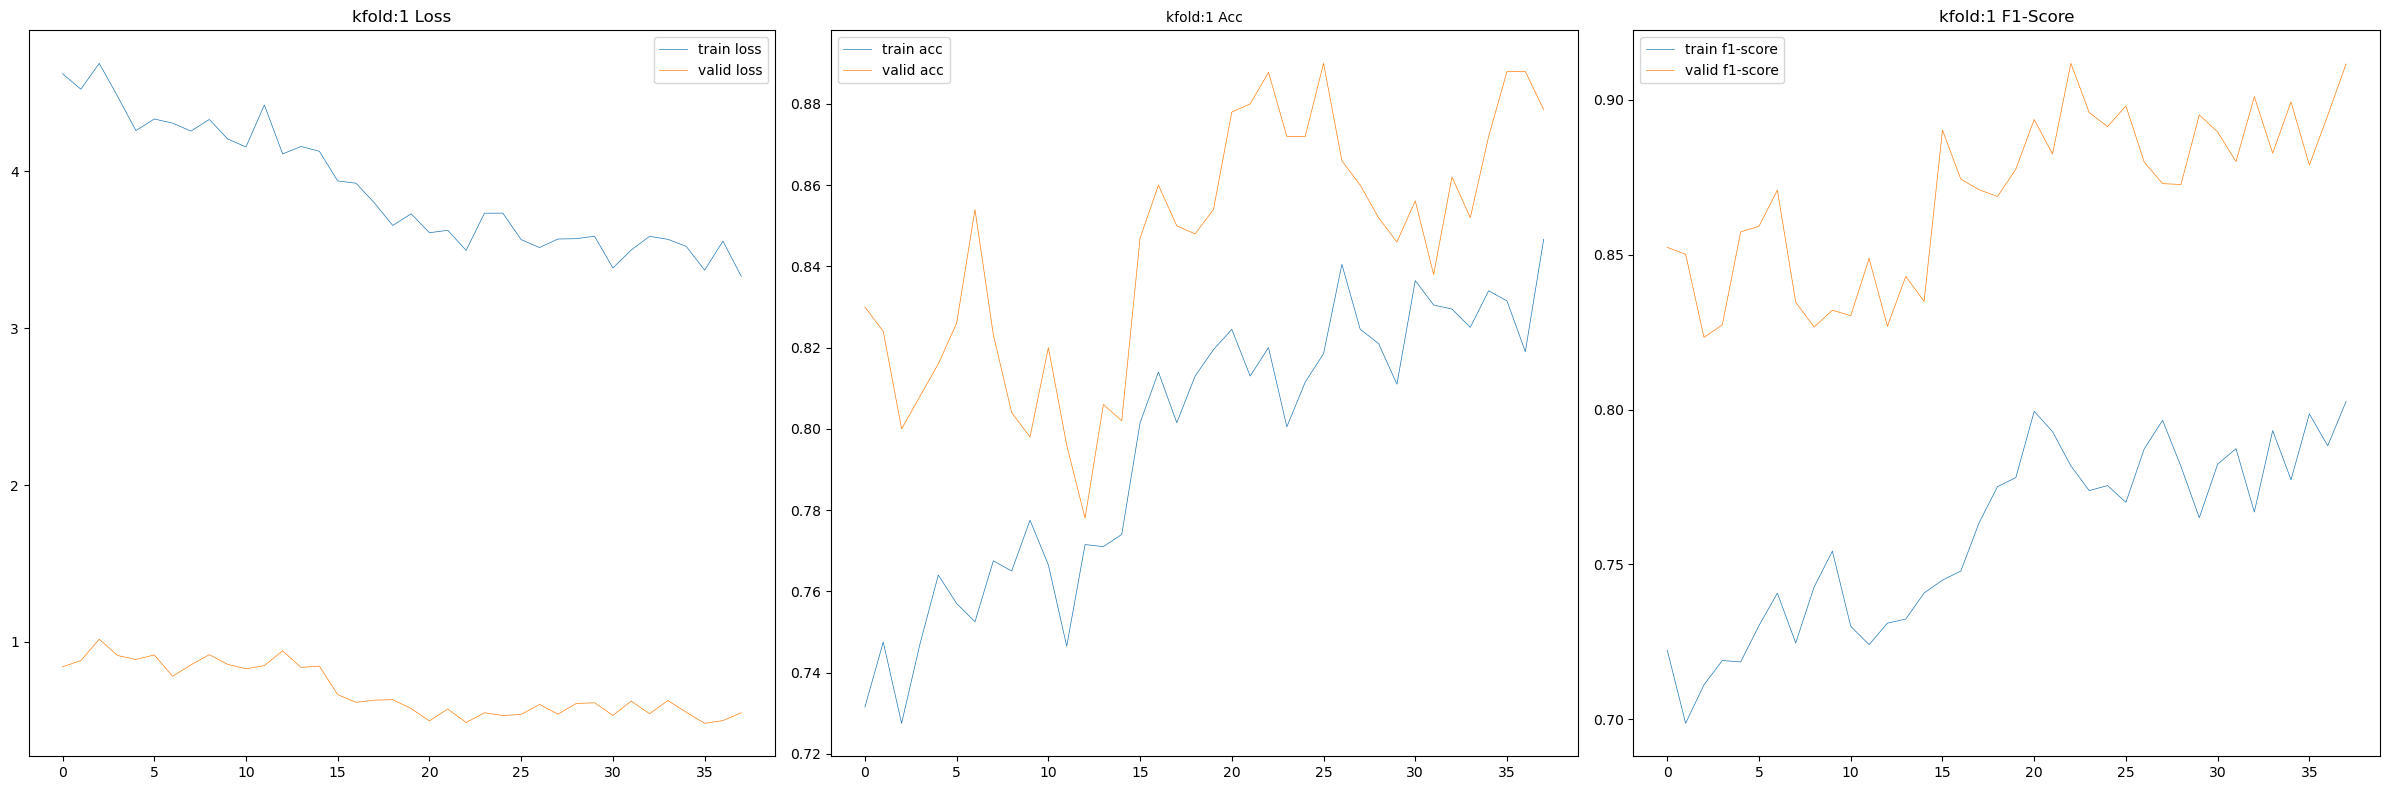

When 2-fold : len(train)=14906 len(valid)=3726

When 2-fold : [trainbacth:746] [validbacth:38]

========EPOCH:[0/5] StepLR:[0.001]=========

Start For Training! EPOCH: 0


100%|██████████| 746/746 [42:31<00:00,  3.42s/it]


Start For Validations! EPOCH: 0


100%|██████████| 38/38 [08:00<00:00, 12.65s/it]


The checkpoint has been established. [FILE: /home/u2020212236/jupyterlab/models/kfold2_ckpt_checkpoint.pth] 

========EPOCH:[1/5] StepLR:[0.001]=========

Start For Training! EPOCH: 1


100%|██████████| 746/746 [42:31<00:00,  3.42s/it]


Start For Validations! EPOCH: 1


100%|██████████| 38/38 [07:59<00:00, 12.62s/it]


The checkpoint has been established. [FILE: /home/u2020212236/jupyterlab/models/kfold2_ckpt_checkpoint.pth] 

========EPOCH:[2/5] StepLR:[0.0001]=========

Start For Training! EPOCH: 2


100%|██████████| 746/746 [41:45<00:00,  3.36s/it]


Start For Validations! EPOCH: 2


100%|██████████| 38/38 [07:56<00:00, 12.54s/it]


The checkpoint has been established. [FILE: /home/u2020212236/jupyterlab/models/kfold2_ckpt_checkpoint.pth] 

========EPOCH:[3/5] StepLR:[0.0001]=========

Start For Training! EPOCH: 3


100%|██████████| 746/746 [42:27<00:00,  3.41s/it]


Start For Validations! EPOCH: 3


100%|██████████| 38/38 [07:58<00:00, 12.60s/it]


The checkpoint has been established. [FILE: /home/u2020212236/jupyterlab/models/kfold2_ckpt_checkpoint.pth] 

========EPOCH:[4/5] StepLR:[0.0001]=========

Start For Training! EPOCH: 4


100%|██████████| 746/746 [42:33<00:00,  3.42s/it]


Start For Validations! EPOCH: 4


100%|██████████| 38/38 [07:58<00:00, 12.60s/it]


The checkpoint has been established. [FILE: /home/u2020212236/jupyterlab/models/kfold2_ckpt_checkpoint.pth] 


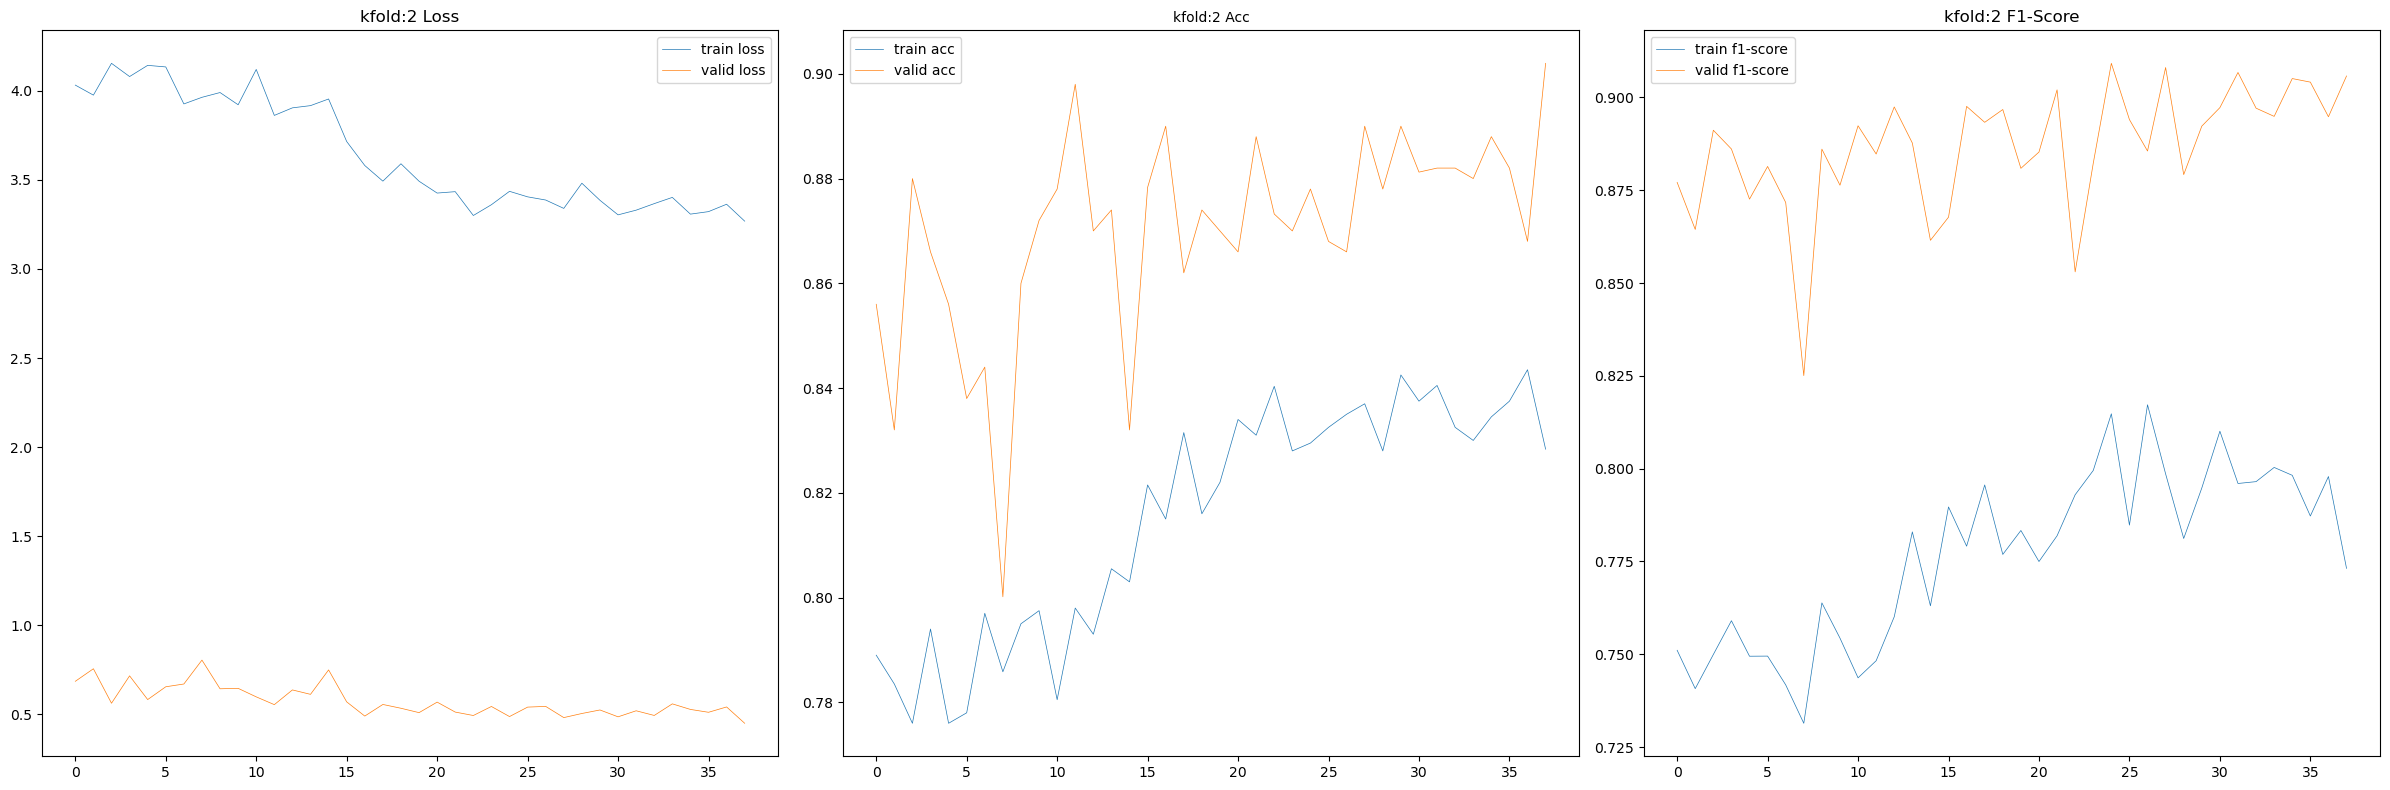

When 3-fold : len(train)=14906 len(valid)=3726

When 3-fold : [trainbacth:746] [validbacth:38]

========EPOCH:[0/5] StepLR:[0.001]=========

Start For Training! EPOCH: 0


 65%|██████▍   | 484/746 [27:26<15:00,  3.44s/it]

In [ ]:
#---------------------------------------------------------------#
#                         Main Code                             #
#---------------------------------------------------------------#
# some optional parameters will be showed as follow :           #
#  1. learning_rate: 1e-3 --> 1e-4                              #
#  2. batch_size: 20. Although it is set to 20, it will become  #
#                  40 when training.                            #
#  3. n-folds: 5, the dataset will be divided into 5 parts.     #
#  4. epoch : 5, the model will be trained 5 times each time    #
#             in k-fold cross validation.                       #
# Models :                                                      #
#  1. resnext50_32x4d pretrained model.                         #
#  2. efficientnet-b0 pretrained model.                         #
#  3. resnet18 pretrained model.                                #
# Loss :                                                        #
#  1. threshold bounded log-sum-exp & pairwise rank-based       #
#     (TLPR) loss.                                              #
#---------------------------------------------------------------#

# clear cuda memory
torch.cuda.empty_cache()

# load resnext50_32x4d pretrained model
seresnet = models.resnext50_32x4d(pretrained=True)
in_features = seresnet.fc.in_features
seresnet.fc = nn.Linear(in_features,CFG.num_classes,bias=True)

# load resnet50 pretrained model
resnet18 = models.resnet18(pretrained=True)
in_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(in_features,CFG.num_classes,bias=True)

# load efficientnet-b0 pretrained model
efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
in_features = efficientnet._fc.in_features
efficientnet._fc = nn.Linear(in_features,CFG.num_classes,bias=True)

# zip three models into a list
ensemble_models = [seresnet.to(CFG.device), resnet18.to(CFG.device) , efficientnet.to(CFG.device)]
# their names which is used to show clear msg
names = ["seresnet","resnet50","efficientnet-b0"]

# define loss and optim
# criterion = BalancedMultiLabelCrossEntropy().to(rank)
# criterion = AsymmetricLossOptimized().to(rank)
criterion = MultiLabelCrossEntropy().to(CFG.device)
optimizers = [torch.optim.AdamW(ensemble_models[i].parameters(), lr=CFG.lr) for i in range(len(ensemble_models))]

# define metric
train_metrics = Metric(train=True, threshold=0.0)
valid_metrics = Metric(train=False,threshold=0.0)

# record loss for every loss
valid_losses = [[] for i in range(len(ensemble_models))]

# The corresponding subscript at the beginning of the loop, used for breakpoint recovery training
start_index = 0
start_step = 0

#---------------------------------------------------------------#
#                       K-Folds Training                        #
#---------------------------------------------------------------#
# 1. Check the checkpoint file to determine whether to continue # 
#    breakpoint training or restart.                            #
# 2. Divide dataset into two parts which are named Train and    #
#    Valid.                                                     #
# 3. Start training models.                                     #
#---------------------------------------------------------------#

# Check if the checkpoint path exists
if not os.path.isdir(CFG.checkpoints_root):
    os.mkdir(CFG.checkpoints_root)

# Check if there is a checkpoint file
os.chdir(CFG.checkpoints_root)
files = os.listdir(CFG.checkpoints_root)
checkpoints = []

# Exclude interference from other files
for file in files:
    if file.endswith('.pth'):
        checkpoints.append(file)

# Checkpoint file exists
if checkpoints != []:
    # Sort checkpoint files to find the latest model
    target_checkpoint = sorted(checkpoints,key=lambda x:int(x[5]),reverse=True)[0]
    # load the latest model
    load_file = torch.load(target_checkpoint)
    start_index = int(target_checkpoint[5])
    start_step = load_file['step']
    # Determine whether the kth fold has completed ten iterations of the loop
    if start_step == CFG.EPOCH -1:
        start_index += 1
        start_step = 0
    else:
        start_step += 1
        
    # Model and optimizer start loading parameters
    for m in range(len(ensemble_models)):
        ensemble_models[m].load_state_dict(load_file[f'M{m+1}'])
        optimizers[m].load_state_dict(load_file[f"optim{m+1}"])
        if start_step == 0:
            optimizers[m].param_groups[0]['lr'] = CFG.lr
        # schedulers[m].load_state_dict(load_file[f"lr_scheduler{m+1}"])
      
    # logger file adding
    os.chdir(CFG.output_dir)
    logger = get_logger("train_ensemble.log",mode="a")
    print("Keep training: [STEP: {:d}] Load CheckPoint FILE: ./models/{:s}]".format(start_index,target_checkpoint))
    logger.info("Keep training: [STEP: {:d}]  Read file:[FILE: {:s}]".format(start_index,target_checkpoint))
else:
    # logger file start to write
    os.chdir(CFG.output_dir)
    logger = get_logger("train_ensemble.log",mode="w")
    logger.info("Start training")

if os.path.exists("valid_losses.pickle"):
    print("read loss ")
    # Continue to record validation losses for each model
    list_file = open('valid_losses.pickle','rb')
    valid_losses = pickle.load(list_file)

if start_step != 0:
    if os.path.exists("train_metric.pickle"):
        print("read train metric ")
        # Continue to record training losses for each model
        list_file = open('train_metric.pickle','rb')
        train_metrics = pickle.load(list_file)

    if os.path.exists("valid_metric.pickle"):
        print("read valid metric ")
        # Continue to record validation metric for each model
        list_file = open('valid_metric.pickle','rb')
        valid_metrics = pickle.load(list_file)

# K-fold partitioning of data 
kf = KFold(n_splits=CFG.n_folds,shuffle=True,random_state=42)
for_split = train_csv.loc[:,["image","labels"]]
k_folds_datas = kf.split(for_split)

# Start k-fold cross validation. Each traversal requires reloading the corresponding dataset once
for kfold_indexs , (train_datas , valid_datas) in enumerate(k_folds_datas):
    # Skip the current loop
    if kfold_indexs < start_index:
        continue

    ## Print data entries for training and validation sets ## 
    print(f"When {kfold_indexs}-fold : len(train)={train_datas.shape[0]} len(valid)={valid_datas.shape[0]}")
    
    ## Load training datas and validation datas ##
    train_dataset = PlantDataset(root=CFG.train_root,transforms=train_transformations,df=train_csv,kf=train_datas)
    valid_dataset = PlantDataset(root=CFG.train_root,transforms=valid_transformations,df=train_csv,kf=valid_datas)

    trainloader = DataLoader(dataset = train_dataset,batch_size = CFG.train_batch_size,shuffle = True)
    validloader = DataLoader(dataset = valid_dataset,batch_size = CFG.valid_batch_size,shuffle = True)

    # Learning rate decay
    schedulers = [torch.optim.lr_scheduler.MultiStepLR(optimizers[i], milestones=CFG.drop_after_epoch, gamma=0.1, last_epoch=-1) for i in range(len(optimizers))] 
    
    ## Number of batches for printing test and validation sets ##
    print(f"When {kfold_indexs}-fold : [trainbacth:{len(trainloader)}] [validbacth:{len(validloader)}]")
    
    
    ## Start to train ##
    for step in range(start_step,CFG.EPOCH):
        print(f"========EPOCH:[{step}/{CFG.EPOCH}] StepLR:[{optimizers[0].param_groups[0]['lr']}]=========")
        
        ## Calling training functionsk ##
        train(models        = ensemble_models,
              optimizers    = optimizers,
              criterion     = criterion ,
              logger        = logger,
              trainloader   = trainloader,
              train_metrics = train_metrics,
              EPOCH         = step, 
              alpha         = 1.0,
              K_fold        = kfold_indexs)

        ## test in validation dataset ##
        validation(EPOCH         = step,
                   models        = ensemble_models,
                   validloader   = validloader,
                   criterion     = criterion,
                   valid_metrics = valid_metrics,
                   valid_losses  = valid_losses,
                   logger        = logger)

        ## learning rate step ##
        for scheduler in schedulers:
            scheduler.step()

        
        ## save model and optimizers ##
        checkpoint = {
            "step":step
        }
        for i in range(len(ensemble_models)):
            checkpoint[f'M{i+1}'] = ensemble_models[i].state_dict()
            checkpoint[f'optim{i+1}'] = optimizers[i].state_dict()

        checkpoint_file_name = CFG.checkpoints_root + 'kfold{:s}_ckpt_checkpoint.pth'.format(str(kfold_indexs))
        torch.save(checkpoint,checkpoint_file_name)
        print("The checkpoint has been established. [FILE: %s] "%(checkpoint_file_name))
        logger.info("The checkpoint has been established. [FILE: %s] "%(checkpoint_file_name))
        
        # write validation loss to pickle file.
        list_file = open('valid_losses.pickle','wb')
        pickle.dump(valid_losses,list_file)
        list_file.close()
        
        # write training metrics to pickle file.
        metric_file = open('train_metric.pickle','wb')
        pickle.dump(train_metrics,metric_file)
        metric_file.close()
        
        # write validation metrics to pickle file
        metric_file = open('valid_metric.pickle','wb')
        pickle.dump(valid_metrics,metric_file)
        metric_file.close()
        

    # reset the start step to zero
    start_step = 0
    # Draw training and validation evaluation indicators for each fold training.
    plot_metrics(train_metrics  = train_metrics,
                 valid_metrics  = valid_metrics,
                 w1             = 100,
                 w2             = 5,
                 kfold          = kfold_indexs)
    
    # Reset learning rate to 1e-3
    for j in range(len(optimizers)):
        optimizers[j].param_groups[0]['lr'] = CFG.lr

## Draw a loss loss on the validation set for each model ##
plt.figure()
for i in range(len(valid_losses)):
    plt.plot(smooth_(valid_losses[i],38),label=f"{names[i]} valids loss")
plt.legend()
plt.show() 
plt.savefig("Valid Loss.png")

## Best Score
![](./image/1686017067699.png)